# Matrix Factorization with Expander Graphs

## Supporting Functions

### Functions for generating and checking data

In [38]:
# IMPORTS
import numpy as np
import copy
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from numpy import linalg as LA


# DATA GENERATION AND PERFORMANCE CHECKING FUNCTIONS
def generate_latent(n,k,c1,c2):
    b = c2-c1
    a = c1/b
    x = np.zeros(n)
    locs = np.random.permutation(n)[:k]
    x[locs] = 1
    signs = np.sign(np.random.randn(k))
    vals = b*(np.random.rand(k)+a)
    x[locs] = x[locs]*vals*signs
    return x

def generate_exp_dictionary1(m,n,d):
    A = np.zeros((m,n))
    for i in range(n):
        locs = np.random.permutation(m)[:d]
        A[locs,i] = 1
    return A

def generate_exp_dictionary2(m,n,d):
    A = np.zeros((m,n))
    alpha = int(np.floor(m/d))
    c = 0
    while c<n:
        perm = np.random.permutation(m)
        zeta = min(n-c, alpha)
        for j in range(zeta):
            locs = perm[j*d:(j+1)*d]
            A[locs,c] = 1
            c = c+1
    return A

def check_dictionary(eps,n,d,A):
    t = (1-4*eps)*d
    mu_A = np.max(np.transpose(A)@A - d*np.identity(n))
    if mu_A >= t:
        print("Generation error, A is not expander for this value of epsilon, mu_A = ", str.format('{0:.2f}', mu_A),", tau = ", str.format('{0:.2f}', t), ".")
        passed = False
    else:
        print("A passes coherence test, mu_A = ", str.format('{0:.2f}', mu_A),", tau = ", str.format('{0:.2f}', t), ".")
        passed = True
    return passed  
        
def check_recon_A(A,A_rec,d,eps,n):
    print("Checking reconstruction of A.")
    col_sum = sum(A_rec)
    print(str.format('{0:.1f}',100*len(col_sum[col_sum==d])/n), "% of columns fully formed.")
    print(str.format('{0:.1f}',100*(n - len(col_sum[col_sum==d]) - len(col_sum[col_sum==0]))/n) , "% of columns partially formed.")
    print(str.format('{0:.1f}', 100*len(col_sum[col_sum==0])/n), "% of columns have no entries.")
    overlaps = np.transpose(A_rec)@A
    A_rec_col, A_col = np.where(overlaps>(1-4*eps)*d)
    if len(col_sum[col_sum==0])<n:
        print(str.format('{0:.1f}', 100*len(A_rec_col)/(n - len(col_sum[col_sum==0]))), "% of reconstructed (fully or partially) columns match with a column in target matrix.")  
    error = 0
    missing = 0
    P = np.zeros((n,n))
    for i in range(len(A_rec_col)):
        diff = A_rec[:, A_rec_col[i]] - A[:,A_col[i]]
        error = error + sum(abs(diff[diff==1]))
        missing = missing + sum(abs(diff[diff==-1]))
        P[A_col[i], A_rec_col[i]] = 1
    print(str.format('{0:.0f}', 100*(missing+d*n-len(A_rec_col)*d)/(d*n)), "% of entries missing in total.")
    print(str.format('{0:.0f}', missing), "entries missing in matched columns.")
    print(str.format('{0:.0f}', error), "entries wrong in matched columns.")
    return P
    
def check_recon_X(X,X_rec,P,N,k,n):
    X_perm = P@X_rec
    print("Checking the values of X recovered.")
    tol = 10**-6
    total_entries = N*k
    total_entries_recovered = 0
    correct_loc_correct_val = 0
    correct_loc_wrong_val = 0
    wrong_loc = 0
    missing = 0
    passed = True
    for i in range(N):
        for j in range(n):
            if abs(X[j,i])>tol and abs(X_perm[j,i])>tol:
                error = abs(X[j,i] - X_perm[j,i])
                if error < tol:
                    correct_loc_correct_val +=1
                else:
                    correct_loc_wrong_val += 1
                    print("Column number = ", i, ", row number = ", j, ", true value = ", X[j,i], "value found = ", X_perm[j,i])
            elif abs(X[j,i])>tol and abs(X_perm[j,i])<tol:
                missing += 1
            elif abs(X[j,i])<tol and abs(X_perm[j,i])>tol:
                wrong_loc += 1
    print(str.format('{0:.1f}', 100*(correct_loc_correct_val/total_entries)), "% of entries correctly recovered.")
    print(str.format('{0:.1f}', 100*(correct_loc_wrong_val/total_entries)), "% of entries in correct location but have wrong value for location.")
    print(str.format('{0:.1f}', 100*(missing/total_entries)), "% of entries missing.")
    return X_perm
    

### Auxillary functions

In [132]:
# USED IN BOTH EXPERIMENTS 1 and 2
def xps2(y,x_vals,x_locs,A_rec,m,eps,d,k):
    tol1 = 10**-8
    tol2 = 10**-8
    y_copy = copy.deepcopy(y)
    t = (1-2*eps)*d
    z1 = len(y_copy);
    W = np.zeros((m,k))
    vals = np.zeros(k)
    q = 0
    for i in range(z1):
        if np.abs(y_copy[i])> tol1:
            locs = list()
            locs.append(i)
            for j in range(i+1, m):
                if np.abs(y_copy[j] - y_copy[i]) < tol2:
                    locs.append(j)
                    y_copy[j] = 0
            match = np.where(y_copy[i]==x_vals)[0]
            if not match:
                if len(locs)>t:
                    W[locs,q] = 1
                    vals[q] = y_copy[i]
                    q = q+1
            elif len(match)==1:
                A_rec[locs, x_locs[match[0]]] = 1
            else:
                print('ERROR - column value matches with more than 1 singleton value already extracted')
        y_copy[i] = 0
    W = W[:,:q]
    vals = vals[:q]
    return [W, A_rec, vals, q]

def process_column2(y, A_rec, x, m, eps, d, k, c, dpid):
    exit_flag = True
    tau = (1-4*eps)*d
    x_locs = np.nonzero(x)[0]
    x_vals = np.zeros(len(x_locs))
    for i in range(len(x_locs)):
        x_vals[i] = x[x_locs[i]]  
    [W, A_rec, vals, q] = xps2(y,x_vals,x_locs,A_rec,m,eps,d,k)
    if q > 0:
        match_check = np.zeros(q) 
        match_col_id = -0.5*np.ones(q)
        data_id = dpid*np.ones(q)          
        if c > 0:           
            matches = np.transpose(W)@A_rec
            matches[matches<=tau] = 0
            matches[matches>tau] = 1
            num_matches = matches.sum(axis=1)
            col_ind = matches@np.arange(c)           
            for i in range(q):
                if num_matches[i] == 0:
                    if c>=n:
                        print("Error: trying to add new column which exceeds total number of columns")
                        exit_flag==False
                elif num_matches[i] == 1:
                    match_check[i] = 1                   
                    z = int(col_ind[i])
                    match_col_id[i] = z
                elif num_matches[i] > 1:
                    print("Error: partial support matches with ", num_matches[i]," partially reconstructed columns of A.")
                    exit_flag = False
    else:
        exit_flag = False
        match_check = []
        match_col_id = []
        data_id = []
    return [W, A_rec, match_check, match_col_id, data_id, vals, exit_flag]

def sort_unmatched_columns(W, eps, d, c): 
    q = W.shape[1]
    col_id_new = -0.5*np.zeros(q)
    tau = (1-4*eps)*d
    matches = np.transpose(W)@W
    matches[matches<=tau] = 0
    matches[matches>tau] = 1
    i =0
    while i<q:
        if sum(matches[:,i]) > 0:
            temp = np.where(matches[:,i]==1)[0]
            col_id_new[temp] = c
            c +=1
            for j in range(len(temp)):
                matches[temp[j],:] = np.zeros(q)
                matches[:,temp[j]] = np.zeros(q)
        i +=1
    return [col_id_new, c]

def update_reconstruction(W, col_id, data_id, vals, A_rec, X_rec):
    for i in range(len(col_id)):
        A_rec[:, int(col_id[i])] += W[:,i]
        X_rec[int(col_id[i]), int(data_id[i])] = vals[i]
    A_rec[A_rec>0] = 1
    return [A_rec, X_rec]


# def l0_decode(y, A, x, num_comp, alpha):
#     tol = 10**-6
#     converged = False
#     r = copy.deepcopy(y)
#     r_old = copy.deepcopy(y) 
#     while converged == False:
#         vals = np.unique(r)
#         vals = vals[vals!=0]
#         for j in range(num_comp):
#             r_0 = np.count_nonzero(r)
#             for v in np.nditer(vals):
#                 u = r - v*A[:,j]
#                 u_0 = np.count_nonzero(u)
#                 if r_0 - u_0 >= alpha:
#                     x[j] = x[j] + v
#             r = y - A@x
#         if LA.norm(r - r_old) < tol or LA.norm(r)<tol:
#             converged = True
#         else:
#             r_old = copy.deepcopy(r)
#     return x

# def l0_decode(r, x, A, num_comp, alpha):
#     vals = np.unique(r)
#     vals = vals[vals!=0]
#     r_0 = np.count_nonzero(r)
#     for j in range(num_comp):
#         for v in np.nditer(vals):
#             u = r - v*A[:,j]
#             if r_0 - np.count_nonzero(u) >= alpha:
#                 x[j] = x[j] + v
#     return x

def l0_decode(y, A, num_comp, alpha):
    tol = 10**-3
    tol2 = 10**-9
    converged = False
    r = copy.deepcopy(y)
    r_old = copy.deepcopy(y)
    x = np.zeros(num_comp)
    iters=1
    while converged == False and iters<10:
        vals = np.unique(r)
        vals = vals[vals!=0]
        for j in range(num_comp):
            r_0 = np.count_nonzero(r)
            for v in np.nditer(vals):
                u = r - v*A[:,j]
                u_0 = np.count_nonzero(u)
                if r_0 - u_0 >= alpha:
                    x[j] = x[j] + v
            r = y - A@x
            r[np.absolute(r)<tol2]=0
        if LA.norm(r - r_old) <= LA.norm(r_old)*tol or LA.norm(r)<=LA.norm(y)*tol:
            converged = True
        else:
            r_old = copy.deepcopy(r)
            iters +=1
        if iters == 10:
            print("Warning: max number of iterations of while loop reached in l0 decode")
            print('Convergence of residual between updates: ', str.format('{0:.2f}', LA.norm(r - r_old)))
            print('Size of final residual: ' ,  str.format('{0:.2f}', LA.norm(r)))
    return x

### EBR Algorithm

In [44]:
def EBR(Y,N,m,n,d,k,eps,max_epochs,A_sparsity,X_sparsity,Y_frob):
    epoch = 0
    c = 0
    tol = 10**-8 # make sure is smaller than 1
    exit_program=False  
    A_rec = np.zeros((m,n))
    X_rec = np.zeros((n,N))
    frob_error_series = np.ones(max_epoch)
    A_entries = np.zeros(max_epoch)
    X_entries = np.zeros(max_epoch)
    total_entries = np.zeros(max_epoch)
    R = copy.deepcopy(Y)    
    start_time = timer()
    while epoch < max_epoch and frob_error_series[epoch] > tol and exit_program==False:            
        num_matched = 0
        num_new = 0    
        for i in range(N):
            [W, A_rec[:,:c], match_check, match_col_id, data_id, vals, supports_found]=process_column2(R[:,i], A_rec[:,:c], X_rec[:,i], m, eps, d, k, c, i)            
            if supports_found == True:
                matches = np.where(match_check==1)[0]
                new = np.where(match_check==0)[0]
                if len(matches)>0:
                    if num_matched > 0:
                        W_match = np.concatenate((W_match, W[:,matches]), axis=1)
                        col_id_match = np.concatenate((col_id_match, match_col_id[matches]), axis=0)
                        data_id_match = np.concatenate((data_id_match, data_id[matches]), axis=0)
                        val_match = np.concatenate((val_match, vals[matches]), axis=0)
                    else:
                        W_match = W[:,matches]
                        col_id_match = match_col_id[matches]
                        data_id_match = data_id[matches]
                        val_match = vals[matches]
                        num_matched += W_match.shape[1]

                if len(new)>0:
                    if num_new > 0:
                        W_new = np.concatenate((W_new, W[:,new]), axis=1)
                        data_id_new = np.concatenate((data_id_new, data_id[new]), axis=0)
                        val_new = np.concatenate((val_new, vals[new]), axis=0)
                    else:
                        W_new = W[:,new]
                        data_id_new = data_id[new]
                        val_new = vals[new]
                        num_new += W_new.shape[1]

        if num_matched > 0 and num_new > 0:
            [col_id_new, c] = sort_unmatched_columns(W_new, eps, d, c)       
            W_all = np.concatenate((W_match, W_new), axis=1)
            col_id_all = np.concatenate((col_id_match, col_id_new), axis=0)
            data_id_all = np.concatenate((data_id_match, data_id_new), axis=0)
            val_all = np.concatenate((val_match, val_new), axis=0)          
        elif num_matched > 0 and num_new == 0:
            W_all = W_match
            col_id_all = col_id_match
            data_id_all = data_id_match
            val_all = val_match     
        elif num_matched == 0 and num_new > 0:
            [col_id_all, c] = sort_unmatched_columns(W_new, eps, d, c)
            W_all = W_new
            data_id_all = data_id_new
            val_all = val_new                       
        elif num_matched == 0 and num_new == 0:
            print("No partial supports recovered, terminating algorithm")
            frob_error_series[epoch:] = frob_error_series[epoch-1]
            A_entries[epoch:] = A_entries[epoch-1]
            X_entries[epoch:] = X_entries[epoch-1]
            total_entries[epoch:] = total_entries[epoch-1]
            exit_program = True
        if exit_program == False:
            [A_rec, X_rec] = update_reconstruction(W_all, col_id_all, data_id_all, val_all, A_rec, X_rec)
            R = Y - A_rec@X_rec
            R[np.absolute(R)<tol] = 0
            frob_error_series[epoch] = np.sqrt(sum(sum(R**2)))
            A_entries[epoch] = np.count_nonzero(A_rec)
            X_entries[epoch] = np.count_nonzero(X_rec)
            total_entries[epoch] = A_entries[epoch] + X_entries[epoch]    
            print('Epoch ', str.format('{0:.0f}', epoch), " processed, l_2 error = ", str.format('{0:.2f}', 100*frob_error_series[epoch]/Y_frob), '%, A l_0 error =', str.format('{0:.2f}', 100*(A_sparsity - A_entries[epoch])/A_sparsity), '%, X l_0 error =', str.format('{0:.2f}', 100*(X_sparsity - X_entries[epoch])/X_sparsity), '%.')
            if epoch == max_epoch:
                print("Maximum number of epochs reached.")
            epoch +=1
    
    end_time = timer()
    comp_time = end_time - start_time
    return [A_rec, X_rec, frob_error_series, total_entries, A_entries, X_entries, comp_time]

In [81]:
def EBR_l0(Y,N,m,n,d,k,eps,max_epochs,A_sparsity,X_sparsity,Y_frob, alpha):
    epoch = 0
    c = 0
    tol = 10**-8 # make sure is smaller than 1
    exit_program=False  
    A_rec = np.zeros((m,n))
    X_rec = np.zeros((n,N))
    frob_error_series = np.ones(max_epoch)
    A_entries = np.zeros(max_epoch)
    X_entries = np.zeros(max_epoch)
    total_entries = np.zeros(max_epoch)
    R = copy.deepcopy(Y)    
    start_time = timer()
    while epoch < max_epoch and frob_error_series[epoch] > tol and exit_program==False:            
        num_matched = 0
        num_new = 0    
        for i in range(N):
            [W, A_rec[:,:c], match_check, match_col_id, data_id, vals, supports_found]=process_column2(R[:,i], A_rec[:,:c], X_rec[:,i], m, eps, d, k, c, i)
            if supports_found == True:
                matches = np.where(match_check==1)[0]
                new = np.where(match_check==0)[0]
                if len(matches)>0:
                    if num_matched > 0:
                        W_match = np.concatenate((W_match, W[:,matches]), axis=1)
                        col_id_match = np.concatenate((col_id_match, match_col_id[matches]), axis=0)
                        data_id_match = np.concatenate((data_id_match, data_id[matches]), axis=0)
                        val_match = np.concatenate((val_match, vals[matches]), axis=0)
                    else:
                        W_match = W[:,matches]
                        col_id_match = match_col_id[matches]
                        data_id_match = data_id[matches]
                        val_match = vals[matches]
                        num_matched += W_match.shape[1]

                if len(new)>0:
                    if num_new > 0:
                        W_new = np.concatenate((W_new, W[:,new]), axis=1)
                        data_id_new = np.concatenate((data_id_new, data_id[new]), axis=0)
                        val_new = np.concatenate((val_new, vals[new]), axis=0)
                    else:
                        W_new = W[:,new]
                        data_id_new = data_id[new]
                        val_new = vals[new]
                        num_new += W_new.shape[1]

        if num_matched > 0 and num_new > 0:
            [col_id_new, c] = sort_unmatched_columns(W_new, eps, d, c)       
            W_all = np.concatenate((W_match, W_new), axis=1)
            col_id_all = np.concatenate((col_id_match, col_id_new), axis=0)
            data_id_all = np.concatenate((data_id_match, data_id_new), axis=0)
            val_all = np.concatenate((val_match, val_new), axis=0)          
        elif num_matched > 0 and num_new == 0:
            W_all = W_match
            col_id_all = col_id_match
            data_id_all = data_id_match
            val_all = val_match     
        elif num_matched == 0 and num_new > 0:
            [col_id_all, c] = sort_unmatched_columns(W_new, eps, d, c)
            W_all = W_new
            data_id_all = data_id_new
            val_all = val_new                       
        elif num_matched == 0 and num_new == 0:
            print("No partial supports recovered, terminating algorithm")
            frob_error_series[epoch:] = frob_error_series[epoch-1]
            A_entries[epoch:] = A_entries[epoch-1]
            X_entries[epoch:] = X_entries[epoch-1]
            total_entries[epoch:] = total_entries[epoch-1]
            exit_program = True    
        
        if exit_program == False:
            [A_rec, X_rec] = update_reconstruction(W_all, col_id_all, data_id_all, val_all, A_rec, X_rec)  
          
            ### RUN l-0 HERE using completed columns ####            
            # Identify the completed columns of A at this iteration
            col_sumA = np.sum(A_rec, axis = 0)
            col_sumA[col_sumA != d] = 0
            comp = np.nonzero(col_sumA)[0]
            num_comp = len(comp)
            
            # Compute the residual based on the completed columns only
            R_l0 = Y - A_rec[:,comp]@X_rec[comp, :]
            R_l0[np.absolute(R_l0)<tol] = 0 
            # Identify which columns of the residual need to still try and decode
            col_sumR = np.sum(np.absolute(R_l0), axis = 0)
            col_sumR[np.absolute(col_sumR) < tol] = 0
            not_dec = np.nonzero(col_sumR)[0]
            num_2_process = len(not_dec)
            
            print("Running l0 decode on epoch ", str.format('{0:.0f}', epoch+1), ': n. of data points of Y still to decode = ', str.format('{0:.0f}', num_2_process), ", n. columns of A completed = ", str.format('{0:.0f}', num_comp),)       
            # Iterate through each column in turn and run l0 decode
#             for j in np.nditer(not_dec):
            for j in range(num_2_process):
#                 print(np.count_nonzero(X_rec[:,j])) 
#                 print(np.count_nonzero(X_rec[comp,j]))
                X_l0_update = l0_decode(R_l0[:,not_dec[j]], A_rec[:,comp], num_comp, alpha)
                X_rec[comp, not_dec[j]] = X_rec[comp, not_dec[j]] + X_l0_update
                if np.mod(int(not_dec[j]),np.ceil(num_2_process/5)) == 0:
                    print("Processed ", str.format('{0:.0f}', j), " data points out of ", str.format('{0:.0f}', num_2_process))
#                 print(np.count_nonzero(X_rec[:,j]))
#                 print(np.count_nonzero(X_rec[comp,j]))
#                 print('next')
            ############################################   
            
            R = Y - A_rec@X_rec
            R[np.absolute(R)<tol] = 0            
            frob_error_series[epoch] = np.sqrt(sum(sum(R**2)))
            A_entries[epoch] = np.count_nonzero(A_rec)
            X_entries[epoch] = np.count_nonzero(X_rec)
            total_entries[epoch] = A_entries[epoch] + X_entries[epoch]    
            print('Epoch ', str.format('{0:.0f}', epoch), " processed, l_2 error = ", str.format('{0:.2f}', 100*frob_error_series[epoch]/Y_frob), '%, A l_0 error =', str.format('{0:.2f}', 100*(A_sparsity - A_entries[epoch])/A_sparsity), '%, X l_0 error =', str.format('{0:.2f}', 100*(X_sparsity - X_entries[epoch])/X_sparsity), '%.')
            if epoch == max_epoch:
                print("Maximum number of epochs reached.")
            epoch +=1
    
    end_time = timer()
    comp_time = end_time - start_time
    return [A_rec, X_rec, frob_error_series, total_entries, A_entries, X_entries, comp_time]

# Experiments analyzing performance of EBR

## Generate synthetic data to run algorithms on

#### Generating a valid dictionary and data

In [56]:
# Dictionary parameters parameters
n = 1200#4000; #800
# beta = 900

m = 900 #int(np.ceil(n*beta));
d = 10; # 9
eps = 1/6;
N = 100


# Generate a dictionary and check that passes necessary test.
num_generations = 0
passed = False
while passed==False and num_generations < 100:
    A = generate_exp_dictionary2(m,n,d);
    passed = check_dictionary(eps,n,d,A)
    num_generations += 1
if passed == True:
    print("Generated dictionary that passes the coherency test")
else:
    print("Failed to generate dictionary that passes the coherency test, consider different parameters")

A_sparsity = np.count_nonzero(A)

Generation error, A is not expander for this value of epsilon, mu_A =  4.00 , tau =  3.33 .
Generation error, A is not expander for this value of epsilon, mu_A =  4.00 , tau =  3.33 .
A passes coherence test, mu_A =  3.00 , tau =  3.33 .
Generated dictionary that passes the coherency test


#### Generate data using dictionary

In [57]:
##### GENERATE LATENT REPRESENTATION
b1=1;
b2=5;
# k = [int(np.ceil(0.01*n)), int(np.ceil(0.04*n)), int(np.ceil(0.07*n)), int(np.ceil(0.1*n))]
k = [int(np.ceil(0.01*n)), int(np.ceil(0.03*n)), int(np.ceil(0.05*n)), int(np.ceil(0.07*n))]
X = np.zeros((len(k), n, N))
Y = np.zeros((len(k), m, N))
Y_frob = np.zeros(len(k))
X_sparsity = np.zeros(len(k))
number_k_to_process = len(k)

for j in range(len(k)):
    for i in range(N):
        X[j,:,i] = generate_latent(n,k[j],b1,b2)
    Y[j] = A@X[j]
    Y_frob[j] = np.sqrt(sum(sum(Y[j]**2)))
    X_sparsity[j] = k[j]*N

## Check that l0 function is working as it should be

In [131]:
ind = 2
alpha=3 #3
N_check = 1

Z = np.zeros((n, N_check))
offset = 28


for j in range(N_check):
    Z[:,j] = l0_decode(Y[ind,:,offset+j], A, n, alpha)
    if np.mod(j,np.ceil(N_check/10)) == 0:
        print(j)
        
check_recon_X(X[ind,:,offset:offset+N_check],Z,np.eye(n),N_check,k[ind],n)

Convergence of residual between updates:  0.00
Size of final residual:  9.52
0
Checking the values of X recovered.
98.3 % of entries correctly recovered.
0.0 % of entries in correct location but have wrong value for location.
1.7 % of entries missing.


array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [88]:
print(np.nonzero(Z))
print(Z[12,1])
print(X[ind,12,1])

(array([  12,   15,   34,   52,   67,   94,  100,  106,  117,  127,  152,
        153,  161,  173,  174,  179,  183,  196,  205,  218,  229,  260,
        272,  282,  288,  295,  301,  304,  306,  314,  326,  329,  333,
        334,  335,  336,  344,  351,  355,  367,  370,  377,  378,  384,
        396,  404,  414,  439,  441,  465,  471,  474,  478,  500,  501,
        508,  548,  561,  572,  575,  593,  594,  603,  608,  620,  626,
        646,  653,  656,  677,  679,  703,  706,  718,  719,  773,  783,
        807,  829,  833,  848,  880,  883,  893,  895,  910,  913,  926,
        938,  962,  964,  968,  968,  979,  982,  986,  989, 1001, 1027,
       1032, 1037, 1048, 1050, 1062, 1067, 1069, 1069, 1074, 1085, 1089,
       1099, 1103, 1104, 1115, 1123, 1124, 1138, 1158, 1187, 1190]), array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,

## Running EBR to recover A and X varying $k/n$

In [143]:
if passed == True:
    eps = 1/6;
    max_epoch = 4
    tol = 10**-8    
    comp_time = np.zeros(len(k))   
    A_rec = np.zeros((len(k),m,n))
    X_rec = np.zeros((len(k),n,N))
    frob_error_series = np.ones((len(k), max_epoch))
    A_entries = np.zeros((len(k), max_epoch))
    X_entries = np.zeros((len(k), max_epoch))
    total_entries = np.zeros((len(k), max_epoch))
    for j in range(number_k_to_process):
        print("Solving problem with k/n = ", str.format('{0:.1f}', 100*k[j]/n), '%, N = ', str.format('{0:.0f}', N))       
        [A_rec[j], X_rec[j], frob_error_series[j], total_entries[j], A_entries[j], X_entries[j], comp_time[j]] = EBR(Y[j],N,m,n,d,k[j],eps,max_epoch,A_sparsity,X_sparsity[j],Y_frob[j])
        print("")
        P = check_recon_A(A, A_rec[j],d,eps,n)
        print("")
        check_recon_X(X[j],X_rec[j],P,N,k[j],n)
        print("")

Solving problem with k/n =  1.0 %, N =  100
Epoch  0  processed, l_2 error =  23.95 %, A l_0 error = 41.39 %, X l_0 error = 1.67 %.
Epoch  1  processed, l_2 error =  13.72 %, A l_0 error = 39.14 %, X l_0 error = 0.00 %.
No partial supports recovered, terminating algorithm

Checking reconstruction of A.
47.8 % of columns fully formed.
15.2 % of columns partially formed.
37.0 % of columns have no entries.
100.0 % of reconstructed (fully or partially) columns match with a column in target matrix.
39 % of entries missing in total.
227 entries missing in matched columns.
0 entries wrong in matched columns.

Checking the values of X recovered.
100.0 % of entries correctly recovered.
0.0 % of entries in correct location but have wrong value for location.
0.0 % of entries missing.

Solving problem with k/n =  3.0 %, N =  100
Epoch  0  processed, l_2 error =  62.82 %, A l_0 error = 22.32 %, X l_0 error = 36.36 %.
Epoch  1  processed, l_2 error =  39.57 %, A l_0 error = 11.57 %, X l_0 error = 13

Running times:
k/n=1.0 %, 3.10372455401 s
k/n=3.0 %, 13.430834531 s
k/n=5.0 %, 41.991499802 s


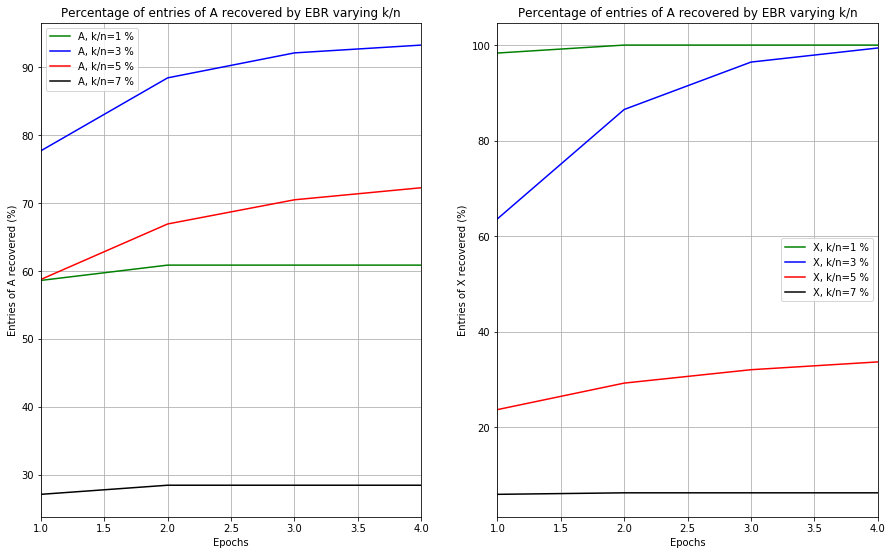

In [145]:
plt.figure(1).clear()

plot_A_entries = 100*A_entries/A_sparsity

plot_X_entries = np.zeros((len(k), max_epoch))
plot_frob = np.zeros((len(k), max_epoch))

for j in range(number_k_to_process):
    plot_X_entries[j,:] = 100*X_entries[j,:]/X_sparsity[j]
plot_epoch = 4

print("Running times:")
print("k/n=%s %%, %s s"%(100*k[0]/n, comp_time[0]))
print("k/n=%s %%, %s s"%(100*k[1]/n, comp_time[1]))      
print("k/n=%s %%, %s s"%(100*k[2]/n, comp_time[2]))  

plt.figure(1)
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(np.arange(max_epoch)+1, plot_A_entries[0], 'g-', label="A, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[1], 'b-', label="A, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[2], 'r-', label="A, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[3], 'k-', label="A, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of A recovered by EBR varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of A recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(max_epoch)+1, plot_X_entries[0], 'g-',label="X, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[1], 'b-',label="X, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[2], 'r-',label="X, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[3], 'k-',label="X, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of A recovered by EBR varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of X recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
# plt.savefig('./figures_ACHA/EBR_performance.eps', format='eps', bbox_inches='tight')

## Running EBR-l0 to recover A and X varying $k/n$

In [133]:
# Extra parameters required for EBR-l0
alpha=3

# Run EBR interweaved with l-0 decode
if passed == True:
    eps = 1/6;
    tol = 10**-8
    comp_time_l0 = np.zeros(len(k))
    A_rec_l0 = np.zeros((len(k),m,n))
    X_rec_l0 = np.zeros((len(k),n,N))
    frob_error_series_l0 = np.ones((len(k), max_epoch))
    A_entries_l0 = np.zeros((len(k), max_epoch))
    X_entries_l0 = np.zeros((len(k), max_epoch))
    total_entries_l0 = np.zeros((len(k), max_epoch))   
    for j in range(number_k_to_process):
        print("Solving problem with k/n = ", str.format('{0:.1f}', 100*k[j]/n), '%, N = ', str.format('{0:.0f}', N))
        [A_rec_l0[j], X_rec_l0[j], frob_error_series_l0[j], total_entries_l0[j], A_entries_l0[j], X_entries_l0[j], comp_time_l0[j]] = EBR_l0(Y[j],N,m,n,d,k[j],eps,max_epoch,A_sparsity,X_sparsity[j],Y_frob[j],alpha)
        print("")
        P = check_recon_A(A, A_rec_l0[j],d,eps,n)
        print("")
        check_recon_X(X[j],X_rec_l0[j],P,N,k[j],n)
        print("")

Solving problem with k/n =  1.0 %, N =  100
Running l0 decode on epoch  1 : n. of data points of Y still to decode =  99 , n. columns of A completed =  413
Processed  0  data points out of  99
Processed  20  data points out of  99
Processed  40  data points out of  99
Processed  60  data points out of  99
Processed  80  data points out of  99
Epoch  0  processed, l_2 error =  22.34 %, A l_0 error = 41.39 %, X l_0 error = 1.00 %.
Running l0 decode on epoch  2 : n. of data points of Y still to decode =  76 , n. columns of A completed =  556
Processed  22  data points out of  76
Processed  37  data points out of  76
Processed  51  data points out of  76
Processed  61  data points out of  76
Processed  72  data points out of  76
Epoch  1  processed, l_2 error =  13.45 %, A l_0 error = 39.04 %, X l_0 error = 0.00 %.
No partial supports recovered, terminating algorithm

Checking reconstruction of A.
47.8 % of columns fully formed.
15.2 % of columns partially formed.
37.0 % of columns have no

Epoch  2  processed, l_2 error =  21.26 %, A l_0 error = 3.48 %, X l_0 error = 3.40 %.
Running l0 decode on epoch  4 : n. of data points of Y still to decode =  49 , n. columns of A completed =  1160
Processed  0  data points out of  49
Convergence of residual between updates:  0.00
Size of final residual:  8.38
Convergence of residual between updates:  0.00
Size of final residual:  15.00
Processed  5  data points out of  49
Convergence of residual between updates:  0.00
Size of final residual:  10.66
Processed  13  data points out of  49
Processed  17  data points out of  49
Convergence of residual between updates:  0.00
Size of final residual:  10.19
Processed  35  data points out of  49
Convergence of residual between updates:  0.00
Size of final residual:  24.28
Processed  45  data points out of  49
Epoch  3  processed, l_2 error =  5.42 %, A l_0 error = 0.72 %, X l_0 error = 0.03 %.

Checking reconstruction of A.
96.7 % of columns fully formed.
3.1 % of columns partially formed.
0

Running times:
k/n=1.0 %, 3.10372455401 s
k/n=3.0 %, 13.430834531 s
k/n=5.0 %, 41.991499802 s


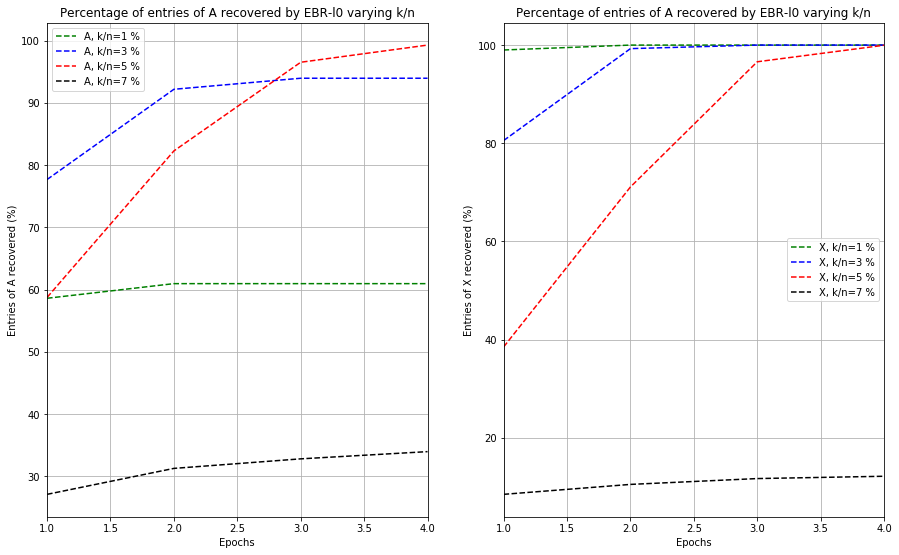

In [146]:
plt.figure(2).clear()

plot_X_entries_l0 = np.zeros((len(k), max_epoch))
plot_A_entries_l0 = 100*A_entries_l0/A_sparsity

for j in range(number_k_to_process):
    plot_X_entries_l0[j,:] = 100*X_entries_l0[j,:]/X_sparsity[j]

plot_epoch = 4

print("Running times:")
print("k/n=%s %%, %s s"%(100*k[0]/n, comp_time[0]))
print("k/n=%s %%, %s s"%(100*k[1]/n, comp_time[1]))      
print("k/n=%s %%, %s s"%(100*k[2]/n, comp_time[2]))  

plt.figure(2)
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[0], 'g--', label="A, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[1], 'b--', label="A, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[2], 'r--', label="A, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[3], 'k--', label="A, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of A recovered by EBR-l0 varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of A recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[0], 'g--',label="X, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[1], 'b--',label="X, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[2], 'r--',label="X, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[3], 'k--',label="X, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of A recovered by EBR-l0 varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of X recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.savefig('./figures_ACHA/EBR_l0_performance.eps', format='eps', bbox_inches='tight')

## Side by side comparison of EBR vs EBR-l0

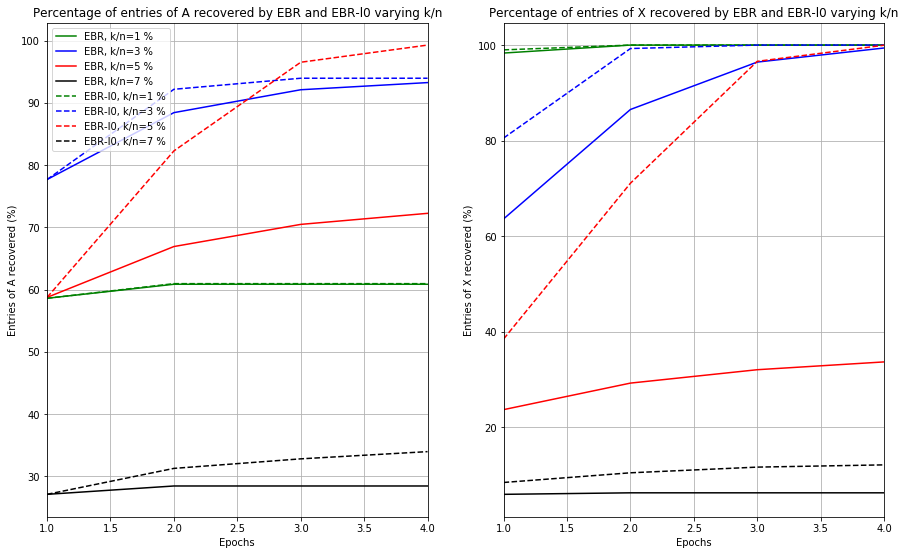

In [147]:
plt.figure(3)
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(np.arange(max_epoch)+1, plot_A_entries[0], 'g-', label="EBR, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[1], 'b-', label="EBR, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[2], 'r-', label="EBR, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[3], 'k-', label="EBR, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[0], 'g--', label="EBR-l0, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[1], 'b--', label="EBR-l0, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[2], 'r--', label="EBR-l0, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[3], 'k--', label="EBR-l0, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of A recovered by EBR and EBR-l0 varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of A recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(max_epoch)+1, plot_X_entries[0], 'g-',label="EBR, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[1], 'b-',label="EBR, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[2], 'r-',label="EBR, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[3], 'k-',label="EBR, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[0], 'g--',label="EBR-l0, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[1], 'b--',label="EBR-l0, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[2], 'r--',label="EBR-l0, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[3], 'k--',label="EBR-l0, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of X recovered by EBR and EBR-l0 varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of X recovered (%)')
plt.xlim(1,plot_epoch)
# plt.legend()
plt.savefig('./figures_ACHA/EBR_vs_EBR_l0_comparison.eps', format='eps', bbox_inches='tight')